In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import math
import numpy as np
import torch.utils.model_zoo as model_zoo

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Normalize(nn.Module):

    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, low_dim=128, in_channel=3, width=1, n_label=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.base = int(64 * width)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, self.base, layers[0])
        self.layer2 = self._make_layer(block, self.base * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, self.base * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(block, self.base * 8, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) #nn.AvgPool2d(7, stride=1)
        self.l2norm = Normalize(2)
        self.n_label = n_label

        print("Resnet with Linear classifier")
        self.linear_K = nn.ModuleList(
            [
                nn.Linear(self.base * 8 * block.expansion, low_dim)
                for  i in range(n_label)
            ]
        )  # create n_label mlp head


        self.classifier = nn.Linear(self.base * 8 * block.expansion, low_dim)




        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, gating=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        gating_logits = self.classifier(x)
        gating_logits = self.l2norm(gating_logits)

        x_list = [self.l2norm( self.linear_K[i](x) ) for i in range(self.n_label)]
        if not gating:
            return torch.stack(x_list, dim=1)
        
        return torch.stack(x_list, dim=1), gating_logits


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model


class ResNet34(nn.Module):
    """Encoder for MiCE"""
    def __init__(self, n_label=10):
        super(ResNet34, self).__init__()
        self.encoder = resnet34(n_label=n_label)
        self.encoder = nn.DataParallel(self.encoder)

    def forward(self, x, gating=False):
        return self.encoder(x, gating=gating)

In [3]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
# from models.normalize import Normalize
import math
from torch.autograd import Variable

import torch
from torch.autograd import Variable
from torch import nn


class Normalize(nn.Module):

    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, pool_len=4, low_dim=128, width=1, n_label=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.base = int(64 * width)
        self.layer1 = self._make_layer(block, self.base, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, self.base * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, self.base * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, self.base * 8, num_blocks[3], stride=2)

        print("ResNet MOE with Linear classifier ")
        self.linear_K = nn.ModuleList(
            [
                nn.Linear(self.base * 8 * block.expansion, low_dim)
                for  i in range(n_label)
            ]
        )

        self.n_label = n_label
        self.classifier = nn.Linear(self.base * 8 * block.expansion, low_dim)


        self.softmax = nn.Softmax(dim=1)

        self.l2norm = Normalize(2)
        self.pool_len = pool_len

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()



    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, gating=False):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, self.pool_len)
        x = out.view(out.size(0), -1)

        # if layer == 6:
        #     return x

        gating_logits = self.classifier(x)
        gating_logits = self.l2norm(gating_logits)

        # x = self.mlp(x)
        # x = self.l2norm(x)

        x_list = [self.l2norm( self.linear_K[i](x) ) for i in range(self.n_label)]
        if not gating:
            return torch.stack(x_list, dim=1)

        return torch.stack(x_list, dim=1), gating_logits


def ResNet18(pool_len = 4, low_dim=128):
    return ResNet(BasicBlock, [2,2,2,2], pool_len, low_dim)

def ResNet34(pool_len = 4, low_dim=128, n_label=10):
    return ResNet(BasicBlock, [3,4,6,3], pool_len, low_dim, width=1, n_label=n_label)

def ResNet50(pool_len = 4, low_dim=128, **kwargs):
    return ResNet(Bottleneck, [3,4,6,3], pool_len, low_dim, **kwargs)

def ResNet101(pool_len = 4, low_dim=128):
    return ResNet(Bottleneck, [3,4,23,3], pool_len, low_dim)

def ResNet152(pool_len = 4, low_dim=128):
    return ResNet(Bottleneck, [3,8,36,3], pool_len, low_dim)


class ResNet34_cifar(nn.Module):
    """Encoder for MiCE"""
    def __init__(self, width=1, low_dim=128, n_label=10):
        super(ResNet34_cifar, self).__init__()
        self.encoder = ResNet34(low_dim=low_dim, n_label=n_label)
        self.encoder = nn.DataParallel(self.encoder)

    def forward(self, x, gating=False):
        return self.encoder(x, gating=gating)

In [4]:
import torch
from torch import nn
import math
import numpy as np
import torch.nn.functional as F

class MiCE_ELBO(nn.Module):
    def __init__(self, inputSize, outputSize, nu, tau=1.0, n_class=10):
        super(MiCE_ELBO, self).__init__()

        print("--------------------Initializing -----------------------------------")
        self.outputSize = outputSize
        self.inputSize = inputSize
        self.queueSize = nu
        self.tau = tau
        self.kappa = self.tau
        self.index = 0
        self.n_class = n_class

        stdv = 1. / math.sqrt(inputSize / 3)
        self.register_buffer('queue', torch.rand(self.queueSize, self.n_class, inputSize).mul_(2 * stdv).add_(-stdv))
        print('using queue shape: ({},{},{})'.format(self.queueSize, self.n_class, inputSize))

        if n_class==10:
            cluster_file = np.loadtxt("/content/drive/MyDrive/project/DL/kernel_paras/meanvar1_featuredim128_class10.mat")
        elif n_class == 20:
            cluster_file = np.loadtxt("/content/drive/MyDrive/project/DL/kernel_paras/meanvar1_featuredim128_class20.mat")
        elif n_class ==15:
            cluster_file = np.loadtxt("/content/drive/MyDrive/project/DL/kernel_paras/meanvar1_featuredim128_class15.mat")

        self.register_buffer('gating_prototype', torch.from_numpy(cluster_file).type(torch.FloatTensor))
        self.expert_prototype = nn.Parameter(torch.Tensor(self.n_class, inputSize))

        self.logSoftmax = torch.nn.LogSoftmax(dim=1)
        self.logSoftmax2 = torch.nn.LogSoftmax(dim=2)
        print("--------------------Initialization Ends-----------------------------------")

    def update_cluster(self, new_center):

        with torch.no_grad():
            new_center = F.normalize(new_center, dim=1)
            out_ids = torch.arange(self.n_class).cuda()
            out_ids = out_ids.long()  # BS x 1
            self.expert_prototype.index_copy_(0, out_ids, new_center) 

    def forward(self, f, v, g,):
        batchSize = f.shape[0] 
        v = v.detach()

        pi_logit_student = torch.div(torch.einsum('kd,bd->bk', [self.gating_prototype.detach().clone(), g]),
                                         self.kappa)  # K x D  vs B x D ---> BS x K
        log_pi = self.logSoftmax(pi_logit_student + 1e-18)
        pi = torch.exp(log_pi)  # p(z | x)

        # positive sample
        v_f = torch.einsum("bkd,bkd->bk", [f, v]).unsqueeze(-1) # BS x K x D --> BS x K x 1
        v_mu = torch.einsum("bkd,kd->bk", [v, F.normalize(self.expert_prototype, dim=1)]).unsqueeze(-1)  # BS x K x 1

        l_pos = (v_f + v_mu)  # BS x K x 1
        l_pos = torch.einsum('bki->kbi', [l_pos]) # BS x K x 1 --> K x BS x 1

        # Negative sample
        queue = self.queue.detach().clone()  # nu x D x K
        queue_f = torch.einsum('vkd,bkd->kbv', [queue, f])  # K x BS x nu
        queue_mu = torch.einsum('vkd,kd->kv', [queue, F.normalize(self.expert_prototype, dim=1)]).unsqueeze(1)  # K x 1 x nu
        del queue

        l_neg = queue_f + queue_mu  # K x BS x nu
        out = torch.div(torch.cat([l_pos, l_neg], dim=2), self.tau) # K x BS x (nu + 1)
        del l_pos, l_neg

        log_phi = self.logSoftmax2(out + 1e-18)
        normalized_phi = torch.exp(log_phi) # p(y | x, z)

        log_phi_pos = log_phi[:, :, 0]
        normalized_phi_pos = normalized_phi[:, :, 0]
        del normalized_phi

        normalized_phi_pos = normalized_phi_pos.transpose(1, 0) * pi                # BS x K
        posterior = torch.div(normalized_phi_pos, normalized_phi_pos.sum(1).view(-1, 1)).squeeze().contiguous()  # BS x K: posterior -> each row = p(z | v_i, x_i)  # BS x Classes, probability
        log_phi_pos = log_phi_pos.transpose(1, 0).squeeze().contiguous() # K x BS -> BS x K
        loss = -torch.sum(posterior * (log_pi + log_phi_pos - torch.log(posterior + 1e-18))) / float(batchSize)

        # update queue using EMA predictions
        with torch.no_grad():
            out_ids = torch.arange(batchSize).cuda()
            out_ids += self.index
            out_ids = torch.fmod(out_ids, self.queueSize)
            out_ids = out_ids.long() 

            self.queue.index_copy_(0, out_ids, v)
            self.index = (self.index + batchSize) % self.queueSize  
        return loss, loss, posterior, log_pi 

In [5]:
from __future__ import print_function
import torch
import torchvision.datasets as datasets
from PIL import Image
import numpy as np


class ThreeCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        x1 = self.base_transform(x)
        x2 = self.base_transform(x)
        x3 = self.base_transform(x)
        return [x1, x2, x3]


def get_dataset_stat(dataset):

    if dataset == 'cifar10':
        image_size = 32
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2470, 0.2435, 0.2616]
        n_class = 10
    elif dataset == 'cifar100' or dataset == 'cifar20':
        image_size = 32
        mean = [0.5071, 0.4867, 0.4408]
        std = [0.2675, 0.2565, 0.2761]
        if dataset == 'cifar100':
            n_class = 100
        else:
            n_class = 20
    elif dataset == 'stl10':
        image_size = 96
        mean = [0.4409, 0.4279, 0.3868]
        std = [0.2683, 0.2610, 0.2687]
        n_class = 10

    return image_size, mean, std, n_class


def create_dataset(dataset, train_transform, test_transform):
    print("Create dataset with tripple transform")
    train_transform = ThreeCropsTransform(train_transform)
    test_transform = ThreeCropsTransform(test_transform)

    if dataset == 'cifar10':
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform,)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform,)

    elif dataset == 'cifar100':
        train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform, )
        test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform, )

    elif dataset == 'cifar20':
        train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform, target_transform=_cifar100_to_cifar20)
        test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform, target_transform=_cifar100_to_cifar20)

    elif dataset == 'stl10':
        train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=train_transform, )
        test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=test_transform, )

    return train_dataset, test_dataset


class ImageFolderTripple(datasets.ImageFolder):
    """Folder datasets which returns the index of the image as well
    """
    def __init__(self, root, transform=None, target_transform=None, two_crop=False):
        super(ImageFolderTripple, self).__init__(root, transform, target_transform)
        self.two_crop = two_crop

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target, index) where target is class_index of the target class.
        """
        path, target = self.imgs[index]
        image = self.loader(path)
        if self.transform is not None:
            img = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)

        img2 = self.transform(image)
        img3 = self.transform(image)

        return [img, img2, img3], target


def _cifar100_to_cifar20(target):
    _dict = {
         0: 4,
         1: 1,
         2: 14,
         3: 8,
         4: 0,
         5: 6,
         6: 7,
         7: 7,
         8: 18,
         9: 3,
         10: 3,
         11: 14,
         12: 9,
         13: 18,
         14: 7,
         15: 11,
         16: 3,
         17: 9,
         18: 7,
         19: 11,
         20: 6,
         21: 11,
         22: 5,
         23: 10,
         24: 7,
         25: 6,
         26: 13,
         27: 15,
         28: 3,
         29: 15,
         30: 0,
         31: 11,
         32: 1,
         33: 10,
         34: 12,
         35: 14,
         36: 16,
         37: 9,
         38: 11,
         39: 5,
         40: 5,
         41: 19,
         42: 8,
         43: 8,
         44: 15,
         45: 13,
         46: 14,
         47: 17,
         48: 18,
         49: 10,
         50: 16,
         51: 4,
         52: 17,
         53: 4,
         54: 2,
         55: 0,
         56: 17,
         57: 4,
         58: 18,
         59: 17,
         60: 10,
         61: 3,
         62: 2,
         63: 12,
         64: 12,
         65: 16,
         66: 12,
         67: 1,
         68: 9,
         69: 19,
         70: 2,
         71: 10,
         72: 0,
         73: 1,
         74: 16,
         75: 12,
         76: 9,
         77: 13,
         78: 15,
         79: 13,
         80: 16,
         81: 19,
         82: 2,
         83: 4,
         84: 6,
         85: 19,
         86: 5,
         87: 5,
         88: 8,
         89: 19,
         90: 18,
         91: 1,
         92: 2,
         93: 15,
         94: 6,
         95: 0,
         96: 17,
         97: 8,
         98: 14,
         99: 13
    }

    return _dict[target]

In [6]:
from __future__ import print_function
import torch
from sklearn.metrics import confusion_matrix
#from models.resnet_MiCE import ResNet34
#from models.resnet_cifar_MiCE import ResNet34_cifar
import numpy as np

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
!pip install scikit-learn==0.22.2
from sklearn.utils.linear_assignment_ import linear_assignment
#from scipy.optimize import linear_sum_assignment as linear_assignment #https://stackoverflow.com/questions/62390517/no-module-named-sklearn-utils-linear-assignment

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def create_model(model_name, n_label=10):
    if model_name == 'resnet34':
        model = ResNet34(n_label=n_label)
        model_ema = ResNet34(n_label=n_label)
    elif model_name == 'resnet34_cifar':
        model = ResNet34_cifar(n_label=n_label)
        model_ema = ResNet34_cifar(n_label=n_label)
    else:
        raise NotImplementedError('model not supported {}'.format(model_name))

    return model, model_ema


def adjust_learning_rate(epoch, opt, optimizer):
    steps = np.sum(epoch > np.asarray(opt.lr_decay_epochs))
    if epoch <= opt.lr_warmup:  # warm up epoch = 10
        print("Linear warm up")
        decay_weight = linear_rampup(epoch, opt.lr_warmup)

        for param_group in optimizer.param_groups:
            param_group['lr'] =  opt.learning_rate * decay_weight
        return

    if steps > 0:
        decay_weight = (opt.lr_decay_rate ** steps)
        for param_group in optimizer.param_groups:
            param_group['lr'] =  opt.learning_rate * decay_weight


def linear_rampup(current, rampup_length):
    """Linear rampup"""
    assert current >= 0 and rampup_length >= 0
    if current >= rampup_length:
        return 1.0
    else:
        return current / rampup_length


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def moment_update(model, model_ema, m):
    """ model_ema = m * model_ema + (1 - m) model """
    for p1, p2 in zip(model.parameters(), model_ema.parameters()):
        p2.data.mul_(m).add_(1-m, p1.detach().data)


def get_shuffle_ids(bsz):
    """generate shuffle ids for ShuffleBN"""
    forward_inds = torch.randperm(bsz).long().cuda()
    backward_inds = torch.zeros(bsz).long().cuda()
    value = torch.arange(bsz).long().cuda()
    backward_inds.index_copy_(0, forward_inds, value)
    return forward_inds, backward_inds


def set_bn_train(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.train()

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)
!pip install scikit-learn==0.22.2
import seaborn as sns; sns.set()
def acc(y_true, y_pred):
    """
    https://github.com/XifengGuo/DEC-keras/blob/master/metrics.py
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)

    cm = confusion_matrix(y_true, y_pred)
    indexes = linear_assignment(_make_cost_m(cm))
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    fig, ax = plt.subplots(figsize=(8,8)) 
    ax = sns.heatmap(cm2,linewidths=.5, annot=True, fmt="d", cmap="Blues")
    #ax = sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")

    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size , cm2


if __name__ == '__main__':
    print()

     |████████████████████████████████| 7.1 MB 4.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.22.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22.2 which is incompatible.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [7]:
# from sklearn.metrics import confusion_matrix
# from scipy.optimize import linear_sum_assignment as linear_assignment
# #from sklearn.utils.linear_assignment_ import linear_assignment
# def acc(true_row_labels, predicted_row_labels):
#     """Get the best accuracy.

#     Parameters
#     ----------
#     true_row_labels: array-like
#         The true row labels, given as external information
#     predicted_row_labels: array-like
#         The row labels predicted by the model

#     Returns
#     -------
#     float
#         Best value of accuracy
#     """

#     cm = confusion_matrix(true_row_labels, predicted_row_labels)
#     indexes = linear_assignment(_make_cost_m(cm))
#     total = 0
#     for row, column in indexes:
#         value = cm[row][column]
#         total += value

#     return (total * 1. / np.sum(cm))

In [7]:
!pip install tensorboard_logger

In [8]:
import sys
sys.argv=['']
del sys

In [10]:
from __future__ import print_function
import os
import sys
import time
import torch
import torch.backends.cudnn as cudnn
import argparse
import numpy as np
import tensorboard_logger as tb_logger
from torchvision import transforms, datasets
#from util import *
#from ELBO import MiCE_ELBO
#from dataset import get_dataset_stat, create_dataset
from torch.utils.data import ConcatDataset


def parse_option():
    parser = argparse.ArgumentParser('argument for training')

    parser.add_argument('--print_freq', type=int, default=50, help='print frequency')
    parser.add_argument('--save_freq', type=int, default=100, help='save frequency')
    parser.add_argument('--batch_size', type=int, default=256, help='batch_size')
    parser.add_argument('--num_workers', type=int, default=32, help='num of workers to use')
    parser.add_argument('--epochs', type=int, default=100, help='number of training epochs')

    # optimization
    parser.add_argument('--learning_rate', type=float, default=1.0, help='learning rate')
    parser.add_argument('--lr_decay_epochs', type=str, default='480,640,800', help='where to decay lr, can be a list')
    parser.add_argument('--lr_decay_rate', type=float, default=0.1, help='decay rate for learning rate')
    parser.add_argument('--weight_decay', type=float, default=1e-4, help='weight decay')
    parser.add_argument('--momentum', type=float, default=0.9, help='momentum')

    # dataset
    parser.add_argument('--dataset', type=str, default='cifar10', choices=['cifar10', 'cifar20', 'stl10'])

    # resume
    parser.add_argument('--resume', default='/content/drive/MyDrive/project/DL/cifar10_nu16384_resnet34_cifar_lr1/ckpt_epoch_0.pth', type=str, metavar='PATH',
                        help='path to latest checkpoint (default: none)')

    # model definition
    parser.add_argument('--model', type=str, default='resnet34_cifar', choices=['resnet34', 'resnet34_cifar'])
    parser.add_argument('--low_dim', type=int, default=128, help='Dimension of each embedding')

    # loss function
    parser.add_argument('--nu', type=int, default=16384, help='Dimension of the queue')
    parser.add_argument('--tau', type=float, default=1.0, help='temperature')

    # EMA setting
    parser.add_argument('--m', type=float, default=0.999, help='exponential moving average weight')

    # GPU setting
    parser.add_argument('--gpu', default=None, type=int, help='GPU id to use.')

    parser.add_argument('--lr_warmup', type=float, default=10, help='Linear warm-up cycle')
    parser.add_argument('--suffix', type=str, default=None, help='suffix to add on the model name')
    parser.add_argument('--data_folder', type=str, default="./", help='path to data')
    parser.add_argument('--model_path', type=str, default="/content/drive/MyDrive/project/DL", help='path to save model')
    parser.add_argument('--tb_path', type=str, default="./tensorboard", help='path to tensorboard')

    opt = parser.parse_args()

    iterations = opt.lr_decay_epochs.split(',')
    opt.lr_decay_epochs = list([])
    for it in iterations:
        opt.lr_decay_epochs.append(int(it))

    opt.model_name = '{}_nu{}_{}_lr{}_bsz{}_epoch{}_tau{}'.format(opt.dataset, opt.nu, opt.model,
                                                        opt.learning_rate,opt.batch_size, opt.epochs, opt.tau)
    opt.model_name += str(opt.suffix)

    opt.model_folder = os.path.join(opt.model_path, opt.model_name)
    if not os.path.isdir(opt.model_folder):
        os.makedirs(opt.model_folder)

    opt.tb_folder = os.path.join(opt.tb_path, opt.model_name)
    if not os.path.isdir(opt.tb_folder):
        os.makedirs(opt.tb_folder)

    return opt

def main():

    args = parse_option()
    if args.gpu is not None:
        print("Use GPU: {} for training".formfat(args.gpu))
    logger = tb_logger.Logger(logdir=args.tb_folder, flush_secs=5)

    #----------------------------------------------prepare dataset--------------------------------------------------------
    image_size, mean, std, n_class = get_dataset_stat(args.dataset)
    args.n_class = n_class
    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.2, 1.)),
        transforms.RandomGrayscale(p=0.2),
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

    train_dataset, test_dataset = create_dataset(args.dataset, train_transform, train_transform)
    full_dataset = ConcatDataset([train_dataset, test_dataset])
    full_loader = torch.utils.data.DataLoader(full_dataset,
                                              batch_size=args.batch_size,
                                              shuffle=True,
                                              num_workers=args.num_workers,
                                              pin_memory=True,
                                              drop_last=True)
    n_full_data = len(full_dataset)


    #----------------------------------------------prepare model/loss/optimizer--------------------------------------------------------
    model, model_ema = create_model(args.model, args.n_class)
    moment_update(model, model_ema, 0)

    elbo = MiCE_ELBO(args.low_dim, n_full_data, args.nu, tau=args.tau, n_class=args.n_class).cuda(args.gpu)

    model = model.cuda()
    model_ema = model_ema.cuda()
    weight_decay = args.weight_decay

    parameters = [{'params': model.parameters(), 'weight_decay': weight_decay},
                  {'params': elbo.parameters(), 'weight_decay': weight_decay}]
    print("Update elbo parameters:", list(parameters[1]['params']), parameters[1]['weight_decay'],)
    optimizer = torch.optim.SGD(parameters,
                                lr=args.learning_rate,
                                momentum=args.momentum,
                                weight_decay=0.0)
    cudnn.benchmark = True

    # optionally resume from a checkpoint
    args.start_epoch = 0
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume, map_location='cpu')

            args.start_epoch = checkpoint['epoch'] + 1
            model.load_state_dict(checkpoint['model'])

            elbo.load_state_dict(checkpoint['elbo'])
            optimizer.load_state_dict(checkpoint['optimizer'])

            for param_group in optimizer.param_groups:
                print(param_group['lr'], param_group['weight_decay'])

            model_ema.load_state_dict(checkpoint['model_ema'])
            print("=> loaded successfully '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
            del checkpoint
            torch.cuda.empty_cache()
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    #----------------------------------------------start training-------------------------------------------------------
    for epoch in range(args.start_epoch, args.epochs + 1):
        adjust_learning_rate(epoch, args, optimizer)
        print("==> training...")

        time1 = time.time()
        log_dict = train_MiCE(epoch, full_loader, model, model_ema, elbo, optimizer, args)
        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        # tensorboard logger
        for key, val in log_dict.items():
            logger.log_value(key, val, epoch)
        logger.log_value('learning_rate', optimizer.param_groups[0]['lr'], epoch)

        # saving the model
        if epoch % 5 == 0:
            print('==> Saving to current...')
            state = {
                    'opt': args,
                    'model': model.state_dict(),
                    'elbo': elbo.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': epoch,
            }
            state['model_ema'] = model_ema.state_dict()
            save_file = os.path.join(args.model_folder, 'current.pth')
            torch.save(state, save_file)
            if epoch % args.save_freq == 0:
                save_file = os.path.join(args.model_folder, 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
                torch.save(state, save_file)
            del state
            torch.cuda.empty_cache()

    return


def train_MiCE(epoch, train_loader, model, model_ema, elbo, optimizer, opt):
    """
    one epoch training for MiCE
    """
    model.train()
    model_ema.eval()
    model_ema.apply(set_bn_train)

    batch_time = AverageMeter()
    data_time = AverageMeter()
    loss_meter = AverageMeter()

    all_cluster_labels = []
    all_true_labels = []
    all_pi_labels = []

    new_center_v = torch.zeros((opt.n_class, opt.low_dim)).cuda()

    end = time.time()
    for idx, (inputs, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        bsz = inputs[0].size(0)
        # ===================forward=====================
        x1, x2, x3 = inputs[0].cuda(), inputs[1].cuda(), inputs[2].cuda()
        shuffle_ids, reverse_ids = get_shuffle_ids(bsz)
        f = model(x1)
        with torch.no_grad():
            x2 = x2[shuffle_ids]
            v = model_ema(x2)
            v = v[reverse_ids]

        _, g = model(x3, True)

        loss, out, posterior, pi_logit = elbo(f, v, g)

        # For cluster label
        feat_pseudo_label = torch.argmax(posterior, dim=1)  # batch x 1
        pi_label = torch.argmax(pi_logit, dim=1)
        all_cluster_labels.extend(list(feat_pseudo_label.data.cpu().numpy()))
        all_true_labels.extend(list(target.data.cpu().numpy()))
        all_pi_labels.extend(list(pi_label.data.cpu().numpy()))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        loss_meter.update(loss.item(), bsz)
        moment_update(model, model_ema, opt.m)

        torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()

        if (idx + 1) % opt.print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'
                  'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})'.format(
                   epoch, idx + 1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=loss_meter))
            sys.stdout.flush()

        # Aggregate the teacher's results for the analytical update (Eq.13)
        with torch.no_grad():
            one_hot_pseudo = torch.nn.functional.one_hot(feat_pseudo_label, num_classes=opt.n_class).float()
            new_center_v += torch.einsum("bk,bkd->kd", [one_hot_pseudo, v])

    elbo.update_cluster(new_center_v)

    all_true_labels = np.array(all_true_labels)
    all_cluster_labels = np.array(all_cluster_labels)
    all_pi_labels = np.array(all_pi_labels)
    cluster_acc = acc(all_true_labels, all_cluster_labels)
    pi_cluster_acc = acc(all_true_labels, all_pi_labels)

    log_dict = {}
    log_dict['loss'] = loss_meter.avg

    log_dict['Train_cluster_acc'] = cluster_acc
    log_dict['Train_pi_cluster_acc'] = pi_cluster_acc
    print(np.bincount(all_cluster_labels))
    print("Cluster ACC:", cluster_acc, "PI Cluster ACC:", pi_cluster_acc)

    return log_dict


if __name__ == '__main__':
    main()

Create dataset with tripple transform


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


KeyboardInterrupt: ignored

In [9]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Create dataset with tripple transform


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
60000
ResNet MOE with Linear classifier 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ResNet MOE with Linear classifier 
--------------------Initializing -----------------------------------
using queue shape: (16384,10,128)
--------------------Initialization Ends-----------------------------------
==> loaded checkpoint '/content/drive/MyDrive/project/DL/ckpt_epoch_1000.pth' (epoch 1000)
==> done
True label stat: [6 9 9 ... 5 1 7]
60000
Cluster label stat: [8 7 7 ... 6 5 9]
60000
True label stat: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
Cluster label stat: [6095 6107 6795 6737 4599 6025 6338 5962 6028 5314]


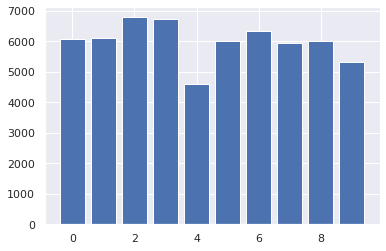

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


CMoE average:  NMI: 0.7388670720549555 | Cluster ACC: (0.83665, array([[5537,   15,   92,   80,   31,   37,   19,    6,  146,   37],
       [  18, 5839,    6,    9,    1,    1,    0,    1,   29,   96],
       [ 268,    1, 3835,  359, 1052,  193,  230,   31,   27,    4],
       [  68,    6,  143, 3906,  158, 1452,  206,   21,   14,   26],
       [  36,    0,  166,  239, 5152,  104,  159,  136,    8,    0],
       [  17,    0,   60, 1476,  203, 4042,   50,  144,    4,    4],
       [  35,    2,  190,  339,   24,   53, 5341,    2,   14,    0],
       [  17,    1,   80,  361,  107,  437,   13, 4970,   12,    2],
       [  58,   27,   16,   12,    6,   16,    6,    1, 5821,   37],
       [  41,  134,   11,   14,    3,    3,    4,    2,   32, 5756]])) | ARI: 0.700505838363436


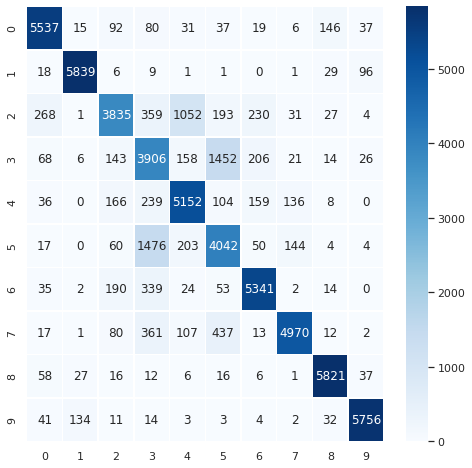

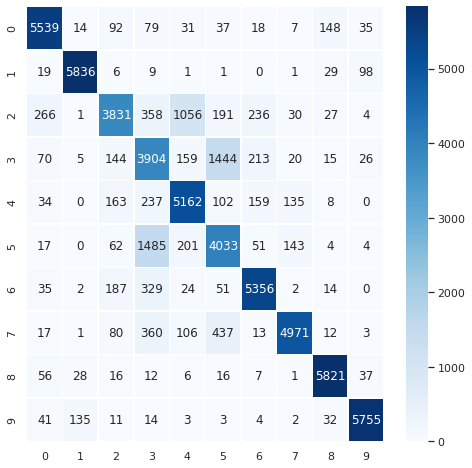

In [10]:
from __future__ import print_function
import os
import torch
import torch.backends.cudnn as cudnn
import argparse
import time
from torchvision import transforms, datasets
from torch.utils.data import ConcatDataset
from sklearn import metrics
import matplotlib.pyplot as plt

def parse_option():
    parser = argparse.ArgumentParser('argument for eval')

    parser.add_argument('--print_freq', type=int, default=10, help='print frequency')
    parser.add_argument('--tb_freq', type=int, default=500, help='tb frequency')
    parser.add_argument('--save_freq', type=int, default=100, help='save frequency')
    parser.add_argument('--batch_size', type=int, default=100, help='batch_size')
    parser.add_argument('--num_workers', type=int, default=32, help='num of workers to use')

    # dataset
    parser.add_argument('--dataset', type=str, default='cifar10', choices=['cifar10', 'cifar20', 'stl10'])

    # resume
    parser.add_argument('--resume', default='', type=str, metavar='PATH',
                        help='path to latest checkpoint (default: none)')

    # model definition
    parser.add_argument('--model', type=str, default='resnet34_cifar', choices=['resnet34', 'resnet34_cifar'])
    parser.add_argument('--low_dim', type=int, default=128, help='Dimension of each embedding')
    parser.add_argument('--test_path', type=str, default='/content/drive/MyDrive/project/DL/ckpt_epoch_1000.pth', help='the model to test')

    # loss function
    parser.add_argument('--nu', type=int, default=16384, help='Dimension of the queue')
    parser.add_argument('--tau', type=float, default=1.0, help='temperature')

    # EMA setting
    parser.add_argument('--m', type=float, default=0.999, help='exponential moving average weight')

    # GPU setting
    parser.add_argument('--gpu', default=None, type=int, help='GPU id to use.')
    parser.add_argument('--suffix', type=str, default=None, help='suffix to add on the model name')
    parser.add_argument('--data_folder', type=str, default="./", help='path to data')
    parser.add_argument('--save_path', type=str, default="./model_save/eval", help='path to save model')
    parser.add_argument('--tb_path', type=str, default="./tensorboard/eval", help='path to tensorboard')

    opt = parser.parse_args()

    opt.model_name = opt.test_path.split('/')[-2]
    opt.tb_folder = os.path.join(opt.tb_path, opt.model_name)
    if not os.path.isdir(opt.tb_folder):
        os.makedirs(opt.tb_folder)

    opt.save_folder = os.path.join(opt.save_path, opt.model_name)
    if not os.path.isdir(opt.save_folder):
        os.makedirs(opt.save_folder)

    if opt.dataset == 'cifar10' or opt.dataset == 'stl10':
        opt.n_class = 10
    elif opt.dataset == 'cifar20':
        opt.n_class = 20
    elif opt.dataset == 'imagenet_dog':
        opt.n_class = 15

    return opt


def get_MiCE_performance(model, model_ema, elbo, dataloader, ndata, n_class, batchSize=100):
    model.eval()
    model_ema.eval()
    all_cluster_labels = []
    all_true_labels = []
    all_pi_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            x1, x2, x3 = inputs[0].cuda(), inputs[1].cuda(), inputs[2].cuda()
            targets = targets.cuda()

            with torch.no_grad():
                f = model(x1)
                v = model_ema(x2)
            _, g = model(x3, True)

            loss, out, posterior, pi_logit = elbo(f, v, g)

            feat_pseudo_label = torch.argmax(posterior, dim=1)  # batch x 1
            pi_label = torch.argmax(pi_logit, dim=1)
            #print (feat_pseudo_label)
            #print (pi_label)
            all_cluster_labels.extend(list(feat_pseudo_label.data.cpu().numpy()))
            all_true_labels.extend(list(targets.data.cpu().numpy()))
            all_pi_labels.extend(list(pi_label.data.cpu().numpy()))

    all_true_labels = np.array(all_true_labels)
    all_cluster_labels = np.array(all_cluster_labels)
    all_pi_labels = np.array(all_pi_labels)
    print ("True label stat:", all_true_labels)
    print (len(all_true_labels))
    print ("Cluster label stat:", all_cluster_labels)
    print (len(all_cluster_labels))
    print("True label stat:", np.bincount(all_true_labels.astype(int)))
    print("Cluster label stat:", np.bincount(all_cluster_labels.astype(int)))
    
    y=np.arange(0,10)
    plt.bar(y,np.bincount(all_cluster_labels.astype(int)))
    plt.show()

    class_names=[0,1,2,3,4,5,6,7,8,9]

    mice_acc = acc(all_true_labels, all_cluster_labels)
    pi_cluster_acc = acc(all_true_labels, all_pi_labels)

    nmi = metrics.normalized_mutual_info_score(labels_true=all_true_labels, labels_pred=all_cluster_labels)
    ari = metrics.adjusted_rand_score(labels_true=all_true_labels, labels_pred=all_cluster_labels)
    return mice_acc, pi_cluster_acc, nmi, ari


def main():
    args = parse_option()
    if args.gpu is not None:
        print("Use GPU: {} for training".format(args.gpu))

    image_size, mean, std, n_class = get_dataset_stat(args.dataset)
    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        normalize,
    ])

    train_dataset, test_dataset = create_dataset(args.dataset, train_transform, train_transform)
    full_dataset = ConcatDataset([train_dataset, test_dataset])
    n_full_data = len(full_dataset)
    print(n_full_data)
    full_loader = torch.utils.data.DataLoader(full_dataset,
                                              batch_size=args.batch_size, shuffle=False,
                                              num_workers=args.num_workers, pin_memory=True)
    model, model_ema = create_model(args.model, n_class)
    elbo = MiCE_ELBO(args.low_dim, n_full_data, args.nu, tau=args.tau, n_class=n_class).cuda(
        args.gpu)

    ckpt = torch.load(args.test_path)
    model.load_state_dict(ckpt['model'])

    model_ema.load_state_dict(ckpt['model_ema'])
    elbo.load_state_dict(ckpt['elbo'])

    print("==> loaded checkpoint '{}' (epoch {})".format(args.test_path, ckpt['epoch']))
    print('==> done')

    model = model.cuda()
    model_ema = model_ema.cuda()
    model.eval()
    model_ema.eval()
    cudnn.benchmark = True

    n_data = len(full_dataset)
    mice_acc, mice_pi_acc, mice_nmi, mice_ari = get_MiCE_performance(
                                                model, model_ema, elbo, full_loader, n_data, n_class
    )
    print("CMoE average:", " NMI:", mice_nmi, "| Cluster ACC:", mice_acc, "| ARI:", mice_ari)

if __name__ == '__main__':
    main()


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]


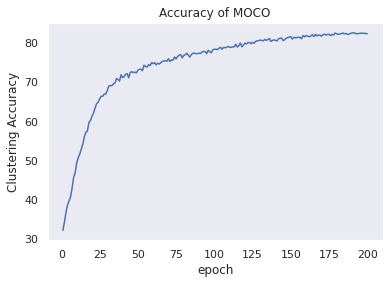

In [14]:
acc=[32.14,34.29,36.74,38.57,39.69,40.71,42.95,45.68,46.83,49.36,50.67,51.62,52.83,54.15,56.02,57.17,57.45,59.65,60.19,61.22,62.08,63.3,64.42,64.83,65.67,66.35,66.33,66.91,66.92,67.80,68.99,69.08,69.03,69.52,69.74,70.87,70.64,70.23,71.84,71.07,71.37,71.98,72.1,71.08,72.45,72.61,72.36,72.52,72.31,72.99,73.22,73.27,72.86,74.27,73.94,73.81,74.38,74.18,74.92,74.66,74.92,74.35,74.77,74.59,74.92,75.21,75.38,75.46,75.28,75.92,75.19,75.63,75.55,76.38,75.87,76.51,76.81,76.99,76.14,76.77,76.96,77.31,76.82,76.34,77.03,77.31,77.33,77.24,77.2,77.34,77.27,77.66,77.82,77.71,77.22,78.05,77.74,77.42,78.17,78.35,78.36,78.25,78.60,78.84,78.36,78.78,78.75,78.8,79.07,78.81,78.84,78.94,78.96,79.60,78.9,79.25,79.93,78.97,79.41,79.88,79.7,80.0,80.08,79.75,80.11,79.86,80.36,80.5,80.54,80.66,80.62,80.47,80.85,80.62,80.81,81.08,80.32,80.60,80.7,80.63,80.46,81.0,81.17,81.19,80.56,80.78,81.17,81.28,81.47,81.51,80.94,81.38,81.26,81.35,81.36,81.39,81.01,81.83,81.49,81.87,81.67,81.53,81.67,82.03,81.58,82.14,81.73,81.96,81.95,81.67,82.03,82.21,81.96,82.09,82.13,81.83,82.12,81.96,82.48,82.28,82.14,82.21,82.34,82.47,82.26,82.36,82.16,82.14,82.39,82.45,82.55,82.44,82.28,82.33,82.38,82.43,82.41,82.39,82.36,82.32]
epoch=np.arange(1,201)
print (epoch)

plt.title("Accuracy of MOCO")
plt.xlabel("epoch")
plt.ylabel("Clustering Accuracy")

plt.plot(epoch, acc)
plt.grid()
plt.show()
